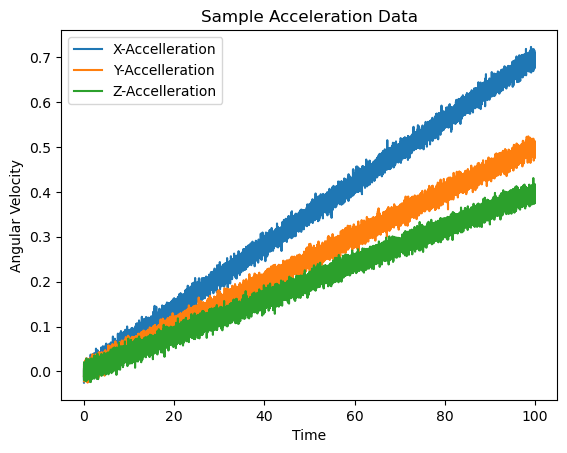

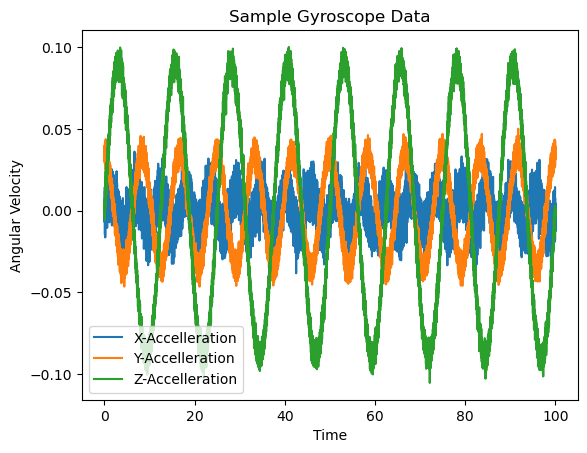

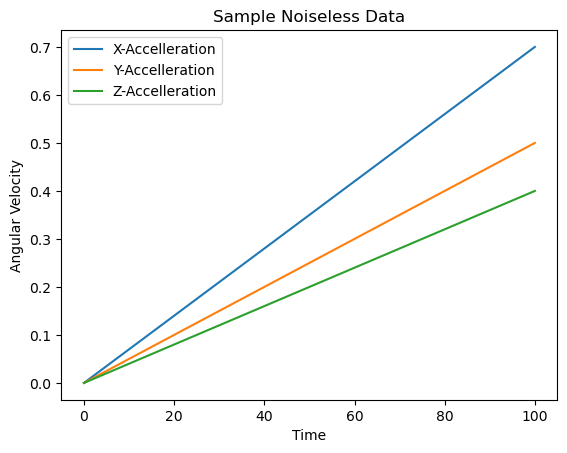

C:\Users\ethan\AppData\Local\Temp\ipykernel_10116\2955475799.py:53: RuntimeWarning: invalid value encountered in divide
  Kalman_Gain = Error_Covariance * np.transpose(Measurement_Matrix) / (Measurement_Matrix *  Error_Covariance * np.transpose(Measurement_Matrix) + Measurement_Variance_Matrix)
C:\Users\ethan\AppData\Local\Temp\ipykernel_10116\2955475799.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Filtered_Angles[j][i] = Data_Estimate[j]


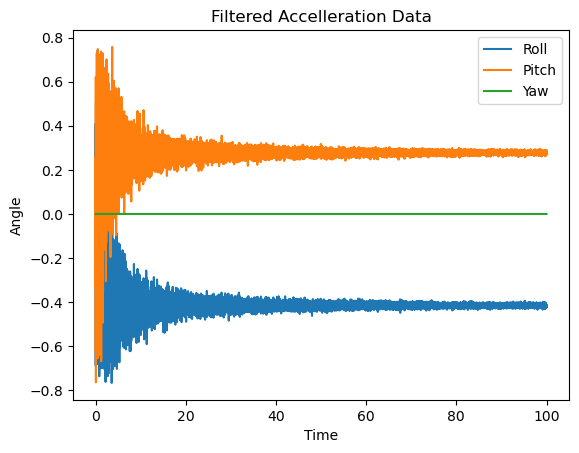

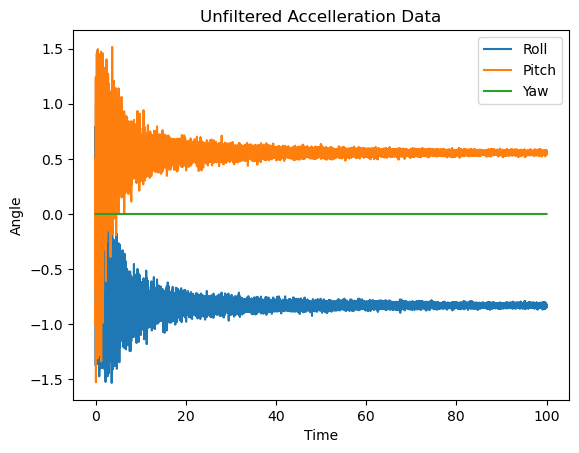

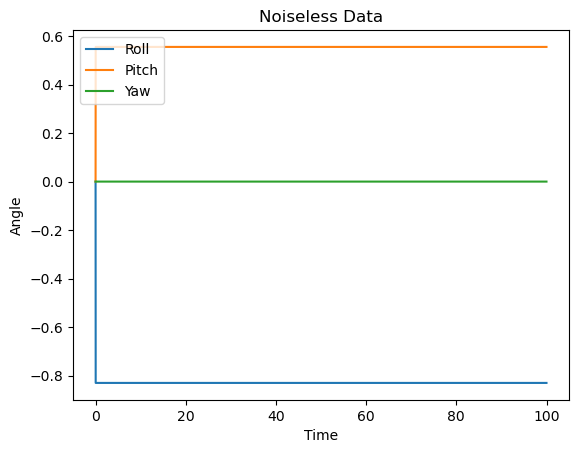

In [25]:
import matplotlib.pyplot as plt 
import random
import numpy as np
import math
from copy import deepcopy

def Symmetric_Skew_Matrix(Vector_Input, Element):
    
    Skew_Matrix = [[0, -Vector_Input[2][Element], Vector_Input[1][Element]],
           [ Vector_Input[2][Element], 0, -Vector_Input[0][Element]],
           [-Vector_Input[1][Element], Vector_Input[0][Element], 0]]
    
    return Skew_Matrix

def Accelleration_To_EulerAngles(accelData,i):

    Pitch = math.atan2(-(accelData[0][i]), np.sqrt(accelData[1][i]**2 + accelData[2][i]**2))
    Roll = math.atan2(accelData[1][i], np.sqrt(accelData[0][i]**2 + accelData[2][i]**2))

    Yaw = 0 #Data from interferometercrequired for calculations here - (Lois & Seb)
    
    Euler_Angles = [Pitch, Roll, Yaw]

    return Euler_Angles

def Plot(x,y,xlabel,ylabel,title,legend):
    plt.plot(x,y,label=legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

def Kalman_Filter(Accelleration_Data, Gyroscope_Data, No_Noise_Data):

    Current_Estimate = [0 ,0 ,0]

    Measurement_Matrix = np.eye(3)
    Error_Covariance_Matrix = np.eye(3)

    Process_Variance_Matrix = (Process_Variance * np.eye(3))
    Measurement_Variance_Matrix = (Measurement_Variance * np.eye(3))
    
    Filtered_Angles = np.zeros((3, len(Time)))
    Unfiltered_Angles = np.zeros((3, len(Time)))
    
    for i in range(0, len(Time)): 
        
        Time_Evolutions = [[element * Time_Step for element in sublist] for sublist in Symmetric_Skew_Matrix(Gyroscope_Data,i)]
        Rotation_Transform = np.eye(3) + Time_Evolutions 
        Predicted_Data = (np.dot(Rotation_Transform, Current_Estimate)).reshape((3,1))
        Error_Covariance = Rotation_Transform*Error_Covariance_Matrix*np.transpose(Rotation_Transform) + Process_Variance_Matrix 
        
        Kalman_Gain = Error_Covariance * np.transpose(Measurement_Matrix) / (Measurement_Matrix *  Error_Covariance * np.transpose(Measurement_Matrix) + Measurement_Variance_Matrix)
        Euler_Angles = Accelleration_To_EulerAngles(Accelleration_Data,i)
        Measurement_Residual = np.transpose(Euler_Angles).reshape((3,1))  - np.dot(Measurement_Matrix, Predicted_Data)
        Data_Estimate = Predicted_Data  + np.dot(np.nan_to_num(Kalman_Gain),  Measurement_Residual)
        Error_Covariance_Matrix  = (np.eye(3) - Kalman_Gain * Measurement_Matrix) * Error_Covariance
    
        No_Noise_Euler_Angles = Accelleration_To_EulerAngles(No_Noise_Data,i)
      
        for j in range(0,3):

            Filtered_Angles[j][i] = Data_Estimate[j]
            Unfiltered_Angles[j][i] = Euler_Angles[j]
            No_Noise_Data[j][i] = No_Noise_Euler_Angles[j]
        
    return Time_Evolutions, Filtered_Angles, Unfiltered_Angles,  No_Noise_Data
   

Time_Step = 0.005
Final_Time = 100
Time = np.arange(0, Final_Time, Time_Step)

Process_Variance = 0.2
Measurement_Variance = 0.4 

noNoiseMeasurements = [0.007*Time, 0.005*Time, 0.004*Time]
 
X_Acceleration = 0.007*Time + 0.01*np.random.normal(0, 1, len(Time))
Y_Acceleration = 0.005*Time + 0.01*np.random.normal(0, 1, len(Time))
Z_Acceleration = 0.004*Time + 0.01*np.random.normal(0, 1, len(Time))

X_Data = 0.012*np.sin(2*np.pi*0.18*Time)+0.007*np.random.normal(0, 1, len(Time))
Y_Data = 0.035*np.cos(2*np.pi*0.12*Time)+0.004*np.random.normal(0, 1, len(Time))
Z_Data = 0.09*np.sin(2*np.pi*0.08*Time)+0.004*np.random.normal(0, 1, len(Time))

Accelleration_Measurements = [X_Acceleration, Y_Acceleration, Z_Acceleration]; 
Gyroscope_Measurements = [X_Data, Y_Data, Z_Data]; 

Data_for_Plotting = [Accelleration_Measurements, Gyroscope_Measurements, noNoiseMeasurements]

Plot_Legend = ['X-Accelleration','Y-Accelleration','Z-Accelleration']
Plot_Titles = ['Sample Acceleration Data', 'Sample Gyroscope Data','Sample Noiseless Data']

for i in range(0,3):
    Plot(Time, Data_for_Plotting[i][0], '', '', Plot_Titles[i], Plot_Legend[0])
    Plot(Time, Data_for_Plotting[i][1], '', '', Plot_Titles[i], Plot_Legend[1])
    Plot(Time, Data_for_Plotting[i][2], 'Time', 'Angular Velocity',Plot_Titles[i], Plot_Legend[2])
    plt.show()


Time_Evolutions, Filtered_Angles, Unfiltered_Angles, No_Noise_Data = Kalman_Filter(Accelleration_Measurements, Gyroscope_Measurements, noNoiseMeasurements) 

Data_for_Plotting = [Filtered_Angles, Unfiltered_Angles, No_Noise_Data]

Plot_Legend = ['Roll','Pitch','Yaw']
Plot_Titles = ['Filtered Accelleration Data', 'Unfiltered Accelleration Data', 'Noiseless Data']

for i in range(0,3):
    Plot(Time,Data_for_Plotting[i][0],'',' ', Plot_Titles[i],Plot_Legend[0])
    Plot(Time,Data_for_Plotting[i][1],'',' ', Plot_Titles[i],Plot_Legend[1])
    Plot(Time,Data_for_Plotting[i][2],'Time','Angle', Plot_Titles[i],Plot_Legend[2])
    plt.show()
